# Laborator 6 - Segmentare Semantică

În acest laborator veți construi și antrena o rețea complet convoluțională (***FCN - Fully Convolutional Network***), al cărei rezultat este o imagine (nu doar o clasificare). Veți implementa trei tehnici speciale: ***convoluții 1x1***, ***upsampling*** și ***skip layers*** pentru a vă antrena propriul FCN.

Veți începe de la un model pre-antrenat pe ImageNet (***VGG16***). După eliminarea straturilor de clasificare (fully connected layers), veți putea adăuga cele trei tehnici (conv. 1x1, upsampling și skip layers) pentru a obține un FCN capabil să clasifice fiecare pixel din imagine.

Veți construi o rețea de segmentare semantică pentru a identifica spațiul liber pe drum (veți folosi setul de date [Kitti Road](http://www.cvlibs.net/datasets/kitti/eval_road.php)).

## De ce FCN?

O rețea convoluțională normală constă dintr-o serie de straturi convoluționale, urmată de straturi fully connected și, în cele din urmă, de o funcție de activare Softmax. Aceasta este o arhitectură bună pentru clasificare, însă straturile fully connected nu păstrează informația spațială. FCN păstrează informația spațială în întreaga rețea (FCN funcționează cu imagini de orice dimensiune).

Din punct de vedere structural, FCN este compusă din două părți: encoder (VGG, ResNet - extrage caracteristici din imagine) și decoder (mărește outputul encoderului pentru a fi de aceeași dimensiune ca imaginea originală; astfel, se realizează clasificarea fiecărui pixel individual din imaginea originală)

---

![alt text](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/05d20ad124a8696f387e6c9632dec0b31251df64/4-Figure3-1.png)

In [2]:
from google.colab import files
uploaded = files.upload()
print("OK")

Saving helper.py to helper.py
Saving project_tests.py to project_tests.py
OK


In [3]:
# Install dependencies
!apt-get update
!apt-get install ffmpeg
!pip install moviepy tqdm

# Download & Extract the Kitti Road dataset
!mkdir ./data ./runs ./saved_models
!wget --progress=bar:force http://kitti.is.tue.mpg.de/kitti/data_road.zip -P ./data
!unzip ./data/data_road.zip -d ./data

Get:1 http://security.ubuntu.com/ubuntu artful-security InRelease [83.2 kB]
Hit:2 http://archive.ubuntu.com/ubuntu artful InRelease
Get:3 http://archive.ubuntu.com/ubuntu artful-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu artful-backports InRelease [74.6 kB]
Get:5 http://security.ubuntu.com/ubuntu artful-security/universe amd64 Packages [74.3 kB]
Get:6 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 Packages [136 kB]
Get:7 http://security.ubuntu.com/ubuntu artful-security/main amd64 Packages [199 kB]
Get:8 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 Packages [325 kB]
Fetched 980 kB in 1s (623 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dbus i965-va-driver libaacs0 libapparmor1 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec57 libavdevice57 libavfilter6
  libavformat57 

Get:21 http://archive.ubuntu.com/ubuntu artful/main amd64 libvdpau1 amd64 1.1.1-3ubuntu1 [25.5 kB]
Get:22 http://archive.ubuntu.com/ubuntu artful/universe amd64 libavutil55 amd64 7:3.3.4-2 [183 kB]
Get:23 http://archive.ubuntu.com/ubuntu artful/universe amd64 libcrystalhd3 amd64 1:0.0~git20110715.fdd2f19-12 [45.8 kB]
Get:24 http://archive.ubuntu.com/ubuntu artful/universe amd64 libmp3lame0 amd64 3.99.5+repack1-9build1 [127 kB]
Get:25 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopenjp2-7 amd64 2.2.0-1 [133 kB]
Get:26 http://archive.ubuntu.com/ubuntu artful/main amd64 libopus0 amd64 1.1.2-1ubuntu1 [159 kB]
Get:27 http://archive.ubuntu.com/ubuntu artful/universe amd64 libshine3 amd64 3.1.1-1 [22.9 kB]
Get:28 http://archive.ubuntu.com/ubuntu artful/main amd64 libsnappy1v5 amd64 1.1.6-4 [16.0 kB]
Get:29 http://archive.ubuntu.com/ubuntu artful/main amd64 libspeex1 amd64 1.2~rc1.2-1ubuntu1 [51.3 kB]
Get:30 http://archive.ubuntu.com/ubuntu artful/universe amd64 libsoxr0 amd64 0.1

Get:96 http://archive.ubuntu.com/ubuntu artful/main amd64 libsensors4 amd64 1:3.4.0-4 [28.8 kB]
Get:97 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libgl1-mesa-dri amd64 17.2.8-0ubuntu0~17.10.1 [5,707 kB]
Get:98 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libgl1-mesa-glx amd64 17.2.8-0ubuntu0~17.10.1 [130 kB]
Get:99 http://archive.ubuntu.com/ubuntu artful/main amd64 libiec61883-0 amd64 1.2.0-2 [23.5 kB]
Get:100 http://archive.ubuntu.com/ubuntu artful/main amd64 libjack-jackd2-0 amd64 1.9.10+20150825git1ed50c92~dfsg-5ubuntu1 [256 kB]
Get:101 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopenal-data all 1:1.17.2-4 [101 kB]
Get:102 http://archive.ubuntu.com/ubuntu artful/universe amd64 libsndio6.1 amd64 1.1.0-3 [23.4 kB]
Get:103 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopenal1 amd64 1:1.17.2-4 [207 kB]
Get:104 http://archive.ubuntu.com/ubuntu artful/main amd64 libasyncns0 amd64 0.8-6 [12.1 kB]
Get:105 http://archive.ubuntu.com/ubun

Get:133 http://archive.ubuntu.com/ubuntu artful/universe amd64 libaacs0 amd64 0.9.0-1 [51.4 kB]
Get:134 http://archive.ubuntu.com/ubuntu artful/universe amd64 libbdplus0 amd64 0.1.2-2 [46.6 kB]
Get:135 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 mesa-va-drivers amd64 17.2.8-0ubuntu0~17.10.1 [1,532 kB]
Get:136 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 mesa-vdpau-drivers amd64 17.2.8-0ubuntu0~17.10.1 [1,658 kB]
Get:137 http://archive.ubuntu.com/ubuntu artful/main amd64 tcpd amd64 7.6.q-26 [23.5 kB]
Get:138 http://archive.ubuntu.com/ubuntu artful/universe amd64 i965-va-driver amd64 1.8.3-1ubuntu1 [633 kB]
Get:139 http://archive.ubuntu.com/ubuntu artful/universe amd64 va-driver-all amd64 1.8.3-2 [4,294 B]
Get:140 http://archive.ubuntu.com/ubuntu artful/main amd64 vdpau-driver-all amd64 1.1.1-3ubuntu1 [4,674 B]
Get:141 http://archive.ubuntu.com/ubuntu artful/main amd64 libtxc-dxtn-s2tc amd64 1.0+git20151227-2 [48.4 kB]
Fetched 60.1 MB in 12s (4,871 kB/s)


Selecting previously unselected package libcrystalhd3:amd64.
Preparing to unpack .../022-libcrystalhd3_1%3a0.0~git20110715.fdd2f19-12_amd64.deb ...
Unpacking libcrystalhd3:amd64 (1:0.0~git20110715.fdd2f19-12) ...
Selecting previously unselected package libmp3lame0:amd64.
Preparing to unpack .../023-libmp3lame0_3.99.5+repack1-9build1_amd64.deb ...
Unpacking libmp3lame0:amd64 (3.99.5+repack1-9build1) ...
Selecting previously unselected package libopenjp2-7:amd64.
Preparing to unpack .../024-libopenjp2-7_2.2.0-1_amd64.deb ...
Unpacking libopenjp2-7:amd64 (2.2.0-1) ...
Selecting previously unselected package libopus0:amd64.
Preparing to unpack .../025-libopus0_1.1.2-1ubuntu1_amd64.deb ...
Unpacking libopus0:amd64 (1.1.2-1ubuntu1) ...
Selecting previously unselected package libshine3:amd64.
Preparing to unpack .../026-libshine3_3.1.1-1_amd64.deb ...
Unpacking libshine3:amd64 (3.1.1-1) ...
Selecting previously unselected package libsnappy1v5:amd64.
Preparing to unpack .../027-libsnappy1v5_1.

Selecting previously unselected package libavc1394-0:amd64.
Preparing to unpack .../052-libavc1394-0_0.5.4-4_amd64.deb ...
Unpacking libavc1394-0:amd64 (0.5.4-4) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../053-libgraphite2-3_1.3.10-2_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.10-2) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../054-libharfbuzz0b_1.4.2-1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (1.4.2-1) ...
Selecting previously unselected package libass9:amd64.
Preparing to unpack .../055-libass9_1%3a0.13.7-2_amd64.deb ...
Unpacking libass9:amd64 (1:0.13.7-2) ...
Selecting previously unselected package libbluray2:amd64.
Preparing to unpack .../056-libbluray2_1%3a1.0.1.deb1-2_amd64.deb ...
Unpacking libbluray2:amd64 (1:1.0.1.deb1-2) ...
Selecting previously unselected package libchromaprint1:amd64.
Preparing to unpack .../057-libchromaprint1_1.4.2-1_amd64.deb ...
Unpacking libchromaprint1:a

Unpacking libx11-xcb1:amd64 (2:1.6.4-3) ...
Selecting previously unselected package libxcb-dri2-0:amd64.
Preparing to unpack .../083-libxcb-dri2-0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-dri2-0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-dri3-0:amd64.
Preparing to unpack .../084-libxcb-dri3-0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-dri3-0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-glx0:amd64.
Preparing to unpack .../085-libxcb-glx0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-glx0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-present0:amd64.
Preparing to unpack .../086-libxcb-present0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-present0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-sync1:amd64.
Preparing to unpack .../087-libxcb-sync1_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-sync1:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxdamage1:am

Selecting previously unselected package libcapnp-0.5.3:amd64.
Preparing to unpack .../113-libcapnp-0.5.3_0.5.3-2ubuntu2_amd64.deb ...
Unpacking libcapnp-0.5.3:amd64 (0.5.3-2ubuntu2) ...
Selecting previously unselected package libboost-filesystem1.62.0:amd64.
Preparing to unpack .../114-libboost-filesystem1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-filesystem1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libmircore1:amd64.
Preparing to unpack .../115-libmircore1_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmircore1:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libmircommon7:amd64.
Preparing to unpack .../116-libmircommon7_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmircommon7:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libprotobuf-lite10:amd64.
Preparing to unpack .../117-libprotobuf-lite10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking l

Setting up libraw1394-11:amd64 (2.1.2-1) ...
Setting up libxcb-xfixes0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-render0:amd64 (1.12-1ubuntu1) ...
Setting up libopenjp2-7:amd64 (2.2.0-1) ...
Setting up libasyncns0:amd64 (0.8-6) ...
Setting up libcdio13:amd64 (0.83-4.2ubuntu1) ...
Setting up libx264-148:amd64 (2:0.148.2795+gitaaa9aa8-1) ...
Setting up libxdamage1:amd64 (1:1.1.4-3) ...
Setting up libxfixes3:amd64 (1:5.0.3-1) ...
Setting up libwavpack1:amd64 (5.1.0-2ubuntu0.3) ...
Setting up libaacs0:amd64 (0.9.0-1) ...
Setting up libnuma1:amd64 (2.0.11-2.1) ...
Setting up libtbb2:amd64 (2017~U7-6) ...
Setting up libelf1:amd64 (0.170-0.1) ...
Setting up libcdio-cdda1:amd64 (0.83-4.2ubuntu1) ...
Setting up libsoxr0:amd64 (0.1.2-2) ...
Setting up libssh-gcrypt-4:amd64 (0.7.5-1) ...
Setting up libasound2-data (1.1.3-5) ...
Setting up libxshmfence1:amd64 (1.2-1) ...
Setting up libwayland-client0:amd64 (1.14.0-1ubuntu0.1) ...
Setting up xkb-data (2.19-1.1ubuntu1) ...
Setting up libcapnp-0.5.

Setting up libboost-filesystem1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libjack-jackd2-0:amd64 (1.9.10+20150825git1ed50c92~dfsg-5ubuntu1) ...
Setting up libopenal1:amd64 (1:1.17.2-4) ...
Setting up libva-drm1:amd64 (1.8.3-2) ...
Setting up libdrm-radeon1:amd64 (2.4.83-1) ...
Setting up librubberband2v5:amd64 (1.8.1-6ubuntu2) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up libvorbisenc2:amd64 (1.3.5-4ubuntu0.2) ...
Setting up libdrm-nouveau2:amd64 (2.4.83-1) ...
Setting up libcaca0:amd64 (0.99.beta19-2build2~gcc5.2) ...
Setting up libmircore1:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Setting up libtheora0:amd64 (1.1.1+dfsg.1-14) ...
Setting up libva-x11-1:amd64 (1.8.3-2) ...
Setting up libavutil55:amd64 (7:3.3.4-2) ...
Setting up libdrm-amdgpu1:amd64 (2.4.83-1) ...
Setting up mesa-vdpau-drivers:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libgbm1:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libass9:amd64 (1:0.13.7-2) ...
Setting up libgl1-mesa-dri:amd64 (17.2.8-0ubu

--2018-05-01 21:44:46--  http://kitti.is.tue.mpg.de/kitti/data_road.zip
Resolving kitti.is.tue.mpg.de (kitti.is.tue.mpg.de)... 192.124.27.130
Connecting to kitti.is.tue.mpg.de (kitti.is.tue.mpg.de)|192.124.27.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘./data/data_road.zip’

data_road.zip       100%[===================>] 449.17M  19.0MB/s    in 30s     

2018-05-01 21:45:16 (15.2 MB/s) - ‘./data/data_road.zip’ saved [470992343/470992343]

Archive:  ./data/data_road.zip
   creating: ./data/data_road/
   creating: ./data/data_road/training/
   creating: ./data/data_road/testing/
   creating: ./data/data_road/training/image_2/
  inflating: ./data/data_road/training/image_2/umm_000032.png  
  inflating: ./data/data_road/training/image_2/umm_000031.png  
  inflating: ./data/data_road/training/image_2/umm_000030.png  
  inflating: ./data/data_road/training/image_2/umm_000029.png  
  inflating: ./data/data_road/tr

  inflating: ./data/data_road/training/image_2/um_000047.png  
  inflating: ./data/data_road/training/image_2/um_000046.png  
  inflating: ./data/data_road/training/image_2/um_000045.png  
  inflating: ./data/data_road/training/image_2/um_000044.png  
  inflating: ./data/data_road/training/image_2/um_000043.png  
  inflating: ./data/data_road/training/image_2/um_000042.png  
  inflating: ./data/data_road/training/image_2/um_000041.png  
  inflating: ./data/data_road/training/image_2/um_000040.png  
  inflating: ./data/data_road/training/image_2/um_000039.png  
  inflating: ./data/data_road/training/image_2/um_000038.png  
  inflating: ./data/data_road/training/image_2/um_000037.png  
  inflating: ./data/data_road/training/image_2/um_000036.png  
  inflating: ./data/data_road/training/image_2/um_000035.png  
  inflating: ./data/data_road/training/image_2/um_000034.png  
  inflating: ./data/data_road/training/image_2/um_000033.png  
  inflating: ./data/data_road/training/image_2/um_00003


  inflating: ./data/data_road/training/image_2/umm_000069.png  
  inflating: ./data/data_road/training/image_2/umm_000068.png  
  inflating: ./data/data_road/training/image_2/umm_000067.png  
  inflating: ./data/data_road/training/image_2/umm_000066.png  
  inflating: ./data/data_road/training/image_2/umm_000065.png  
  inflating: ./data/data_road/training/image_2/umm_000064.png  
  inflating: ./data/data_road/training/image_2/umm_000063.png  
  inflating: ./data/data_road/training/image_2/umm_000062.png  
  inflating: ./data/data_road/training/image_2/umm_000061.png  
  inflating: ./data/data_road/training/image_2/umm_000060.png  
  inflating: ./data/data_road/training/image_2/umm_000059.png  
  inflating: ./data/data_road/training/image_2/umm_000058.png  
  inflating: ./data/data_road/training/image_2/umm_000057.png  
  inflating: ./data/data_road/training/image_2/umm_000056.png  
  inflating: ./data/data_road/training/image_2/umm_000055.png  
  inflating: ./data/data_road/training/


  inflating: ./data/data_road/training/calib/um_000049.txt  
  inflating: ./data/data_road/training/calib/um_000048.txt  
  inflating: ./data/data_road/training/calib/um_000047.txt  
  inflating: ./data/data_road/training/calib/um_000046.txt  
  inflating: ./data/data_road/training/calib/um_000045.txt  
  inflating: ./data/data_road/training/calib/um_000044.txt  
  inflating: ./data/data_road/training/calib/um_000043.txt  
  inflating: ./data/data_road/training/calib/um_000042.txt  
  inflating: ./data/data_road/training/calib/um_000041.txt  
  inflating: ./data/data_road/training/calib/um_000040.txt  
  inflating: ./data/data_road/training/calib/um_000039.txt  
  inflating: ./data/data_road/training/calib/um_000038.txt  
  inflating: ./data/data_road/training/calib/um_000037.txt  
  inflating: ./data/data_road/training/calib/um_000036.txt  
  inflating: ./data/data_road/training/calib/um_000035.txt  
  inflating: ./data/data_road/training/calib/um_000034.txt  
  inflating: ./data/dat


  inflating: ./data/data_road/testing/image_2/um_000094.png  
  inflating: ./data/data_road/testing/image_2/um_000093.png  
  inflating: ./data/data_road/testing/image_2/um_000092.png  
  inflating: ./data/data_road/testing/image_2/um_000091.png  
  inflating: ./data/data_road/testing/image_2/um_000090.png  
  inflating: ./data/data_road/testing/image_2/um_000089.png  
  inflating: ./data/data_road/testing/image_2/um_000088.png  
  inflating: ./data/data_road/testing/image_2/um_000087.png  
  inflating: ./data/data_road/testing/image_2/um_000086.png  
  inflating: ./data/data_road/testing/image_2/um_000085.png  
  inflating: ./data/data_road/testing/image_2/um_000084.png  
  inflating: ./data/data_road/testing/image_2/um_000083.png  
  inflating: ./data/data_road/testing/image_2/um_000082.png  
  inflating: ./data/data_road/testing/image_2/um_000081.png  
  inflating: ./data/data_road/testing/image_2/um_000080.png  
  inflating: ./data/data_road/testing/image_2/um_000079.png  
  infla


  inflating: ./data/data_road/testing/image_2/uu_000032.png  
  inflating: ./data/data_road/testing/image_2/uu_000031.png  
  inflating: ./data/data_road/testing/image_2/uu_000030.png  
  inflating: ./data/data_road/testing/image_2/uu_000029.png  
  inflating: ./data/data_road/testing/image_2/uu_000028.png  
  inflating: ./data/data_road/testing/image_2/uu_000027.png  
  inflating: ./data/data_road/testing/image_2/uu_000026.png  
  inflating: ./data/data_road/testing/image_2/uu_000025.png  
  inflating: ./data/data_road/testing/image_2/uu_000024.png  
  inflating: ./data/data_road/testing/image_2/uu_000023.png  
  inflating: ./data/data_road/testing/image_2/uu_000022.png  
  inflating: ./data/data_road/testing/image_2/uu_000021.png  
  inflating: ./data/data_road/testing/image_2/uu_000020.png  
  inflating: ./data/data_road/testing/image_2/uu_000019.png  
  inflating: ./data/data_road/testing/image_2/uu_000018.png  
  inflating: ./data/data_road/testing/image_2/uu_000017.png  
  infla

  inflating: ./data/data_road/testing/calib/um_000054.txt  
  inflating: ./data/data_road/testing/calib/um_000053.txt  
  inflating: ./data/data_road/testing/calib/um_000052.txt  
  inflating: ./data/data_road/testing/calib/um_000051.txt  
  inflating: ./data/data_road/testing/calib/um_000050.txt  
  inflating: ./data/data_road/testing/calib/um_000049.txt  
  inflating: ./data/data_road/testing/calib/um_000048.txt  
  inflating: ./data/data_road/testing/calib/um_000047.txt  
  inflating: ./data/data_road/testing/calib/um_000046.txt  
  inflating: ./data/data_road/testing/calib/um_000045.txt  
  inflating: ./data/data_road/testing/calib/um_000044.txt  
  inflating: ./data/data_road/testing/calib/um_000043.txt  
  inflating: ./data/data_road/testing/calib/um_000042.txt  
  inflating: ./data/data_road/testing/calib/um_000041.txt  
  inflating: ./data/data_road/testing/calib/um_000040.txt  
  inflating: ./data/data_road/testing/calib/um_000039.txt  
  inflating: ./data/data_road/testing/ca

In [4]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests

from moviepy.editor import VideoFileClip
import scipy.misc
import numpy as np

import sys

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import random

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1613824/45929032 bytes (3.5%)4800512/45929032 bytes (10.5%)8347648/45929032 bytes (18.2%)12001280/45929032 bytes (26.1%)15474688/45929032 bytes (33.7%)19136512/45929032 bytes (41.7%)22503424/45929032 bytes (49.0%)26132480/45929032 bytes (56.9%)29474816/45929032 bytes (64.2%)33062912/45929032 bytes (72.0%)36659200/45929032 bytes (79.8%)40157184/45929032 bytes (87.4%)

In [5]:
# Descărcați modelul VGG pre-antrenat

num_classes = 2
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'

helper.maybe_download_pretrained_vgg(data_dir)
tests.test_for_kitti_dataset(data_dir)

0.00B [00:00, ?B/s]

997MB [00:20, 49.1MB/s]                           


Extracting model...
Tests Passed


### Vizualizare dataset Kitti Road

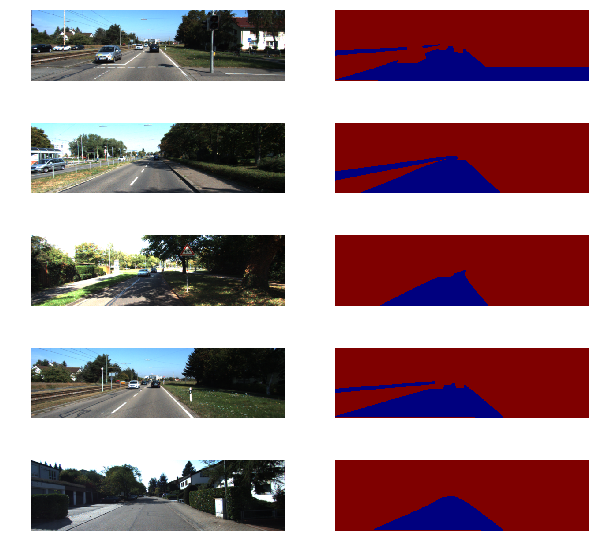

In [7]:
num_samples = 5
get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

plt.figure(figsize=(10, 10))

for batch, (images, labels) in enumerate(get_batches_fn(num_samples)):
  for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(num_samples, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(image, None)
    plt.subplot(num_samples, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(label[:,:,0], 'jet')

In [8]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.7.0


In [9]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


## Cerința 1 - Încărcați în Tensorflow modelul VGG pre-antrenat și obțineți tensorii corespunzători layerelor image_input, pool3, pool4, conv_7, precum și keep_prob (pentru dropout în timpul procesului de fine-tuning)

* Folosiți [`tf.saved_model.loader.load`](https://www.tensorflow.org/api_docs/python/tf/saved_model/loader/load) pentru a încărca modelul și parametrii
* Folosiți [`tf.get_default_graph`](https://www.tensorflow.org/api_docs/python/tf/get_default_graph) pentru a obține graful default pentru threadul curent
* Folosiți [`graph.get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph) pentru a obține tensorii din modelul VGG

![alt text](https://csdl-images.computer.org/trans/tp/2017/04/figures/shelh3-2572683.gif)


In [0]:
def load_vgg(sess, vgg_path):
    """
    Încărcați în Tensorflow modelul VGG pre-antrenat
    :param sess: Sesiunea Tensorflow
    :param vgg_path: Calea către directorul vgg, conținând "variables/" și "saved_model.pb"
    :return: Tuplu de Tensori din modelul VGG (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implementați funcția
    # Folosiți tf.saved_model.loader.load pentru a încărca modelul și parametrii
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    vgg_input_tensor = graph.get_tensor_by_name(vgg_input_tensor_name)
    vgg_keep_prob_tensor = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out_tensor = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    vgg_layer4_out_tensor = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    vgg_layer7_out_tensor = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return vgg_input_tensor, vgg_keep_prob_tensor, vgg_layer3_out_tensor, vgg_layer4_out_tensor, vgg_layer7_out_tensor

In [57]:
tests.test_load_vgg(load_vgg, tf)

Tests Passed


## Cerința 2 - Adăugați layerele corespunzătoare decoderului. Construiți skip-layers folosind layerele vgg

* pentru a evita problema exploziei gradienților, folosiți [***`tf.multiply`***](https://www.tensorflow.org/api_docs/python/tf/multiply) pentru a scala rezultatul layerelor de pooling 3 și 4 înainte de a aplica convoluțiile 1x1 (folosiți `0.0001` pentru pool_3 și `0.01` pentru pool_4)
* folosiți [***`tf.layers.conv2d`***](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d) pentru a adăuga convoluțiile 1x1, pentru a reduce depth-ul layerelor la numărul de clase
* folosiți [***`tf.layers.conv2d_transpose`***](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) pentru a mări rezoluția layerelor (2x pentru conv_7, 2x pentru primul skip-layer (între pool_4 și conv_7 upscaled) și 8x pentru cel de-al 2-lea skip layer (între pool_3 și primul skip-layer upscaled))
* folosiți [***`tf.add`***](https://www.tensorflow.org/api_docs/python/tf/add) pentru skip-layers

***Hint: Folosiți regularizare L2 pentru a preveni overfitting-ul ([`tf.contrib.layers.l2_regularizer`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/l2_regularizer))***

In [0]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Creați layerele pentru FCN; construiți skip-layers folosind layerele vgg
    :param vgg_layer3_out: Tensor pentru layerul 3
    :param vgg_layer4_out: Tensor pentru layerul 4
    :param vgg_layer7_out: Tensor pentru layerul 7
    :param num_classes: Numărul de clase
    :return: Tensorul pentru layerul de output
    """
    # TODO: Implementați funcția
    
    # 1x1 convolution
    vgg_layer7_conv = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 
                                       padding= 'same', 
                                       kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                       kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # upsample
    vgg_layer7_upsample = tf.layers.conv2d_transpose(vgg_layer7_conv, num_classes, 4, 
                                                     strides= (2, 2), 
                                                     padding= 'same', 
                                                     kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                                     kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))

    # 1x1 convolution
    vgg_layer4_conv = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 
                                       padding= 'same', 
                                       kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                       kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    
    # skip layer
    vgg_skip_layer1 = tf.add(vgg_layer7_upsample, vgg_layer4_conv)
    
    # upsample
    vgg_skip_layer1_upsample = tf.layers.conv2d_transpose(vgg_skip_layer1, num_classes, 4,  
                                                          strides= (2, 2), 
                                                          padding= 'same', 
                                                          kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                                          kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    
    # 1x1 convolution
    vgg_layer3_conv = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 
                                       padding= 'same', 
                                       kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                       kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    
    # skip layer
    vgg_skip_layer2 = tf.add(vgg_skip_layer1_upsample, vgg_layer3_conv)
    
    # upsample
    out_layer = tf.layers.conv2d_transpose(vgg_skip_layer2, num_classes, 16,  
                                           strides= (8, 8), 
                                           padding= 'same', 
                                           kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                           kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    
    return out_layer

In [59]:
tests.test_layers(layers)

Tests Passed


## Cerința 3 - Adăugați operațiile de loss și optimizare

* folosiți [***`tf.nn.softmax_cross_entropy_with_logits`***](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) ca funcție de loss
* folosiți [***`tf.train.AdamOptimizer`***](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) ca optimizator

***Hint: ***
 * ***trebuie să însumați loss-ul de regularizare cu loss-ul cross-entropy pentru ca regularizarea să aibă loc (folosiți [`tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES`)](https://www.tensorflow.org/api_docs/python/tf/get_collection) pentru a obține loss-ul de regularizare)***
 * *** `nn_last_layer` și `correct_label` trebuie redimensionați pentru a deveni 2D (fiecare rând va reprezenta un pixel, iar fiecare coloană va reprezenta o clasă)***

In [0]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Adăugați operațiile de loss și optimizare
    :param nn_last_layer: Tensor pentru ultimul layer din rețea
    :param correct_label: Placeholder pentru imaginea ground-truth (imaginea label/mască)
    :param learning_rate: Placeholder pentru learning rate
    :param num_classes: Numărul de clase
    :return: (logits, optimizer, cross_entropy_loss)
    """
    # TODO: Implementați funcția
    # tensor for each pixel with num_class
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1, num_classes))
    
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_loss)
    
    return logits, optimizer, cross_entropy_loss

In [61]:
tests.test_optimize(optimize)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Tests Passed


## Cerința 4 - Antrenați rețeaua și afișați loss-ul în timpul antrenării
* folosiți `0.5` pentru dropout
* folosiți `1e-4` pentru learning rate

In [0]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Antrenați rețeaua și afișați loss-ul în timpul antrenării
    :param sess: Sesiunea Tensorflow
    :param epochs: Numărul de epoci
    :param batch_size: Dimensiunea batch-ului de imagini
    :param get_batches_fn: Funcție pentru a obține batch-uri de imagini. Apelați folosind get_batches_fn(batch_size)
    :param train_op: Operație Tensorflow pentru a antrena rețeaua neurală
    :param cross_entropy_loss: Tensor pentru loss
    :param input_image: Placeholder pentru imagini
    :param correct_label: Placeholder pentru labeluri
    :param keep_prob: Placeholder pentru dropout
    :param learning_rate: Placeholder pentru learning rate
    """
    # TODO: Implementați funcția
    
    for i in range(epochs):
        print('epoch: ' + str(i))
        for image, label in get_batches_fn(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss], 
                               feed_dict={input_image: image, correct_label: label, keep_prob: 0.5, learning_rate: 0.0009})
            print('loss: ' + str(loss))

## BONUS 1 - Aplicați rețeaua neurală pe un video

Metoda `process_image` primește un frame RGB, aplică rețeaua neurală pentru a segmenta drumul (obține o mască), aplică masca peste imaginea originală și o întoarce la output.

In [0]:
def process_image(image):
    """
    Aplică rețeaua neurală unui frame dintr-un video pentru a segmenta drumul
    : param image: Frame RGB
    : return: Imagine RGB cu masca drumului aplicată
    """
    # TODO: Implementați funcția
    
    return None

In [0]:
train_model = True
process_video = False
load_model = False
save_model = False
output_dir = None

# process image parameters
sess = tf.Session()
keep_prob = tf.placeholder(tf.float32)
loggits = tf.placeholder(tf.int32, [None, None, None, 2])
input_image = tf.placeholder(tf.int32, [None, None, 3])

In [0]:
def run():
    global image_shape, logits, sess, keep_prob, input_image, output_dir

    tf.reset_default_graph()
    
    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)
        
        epochs = 30
        batch_size = 8
        learning_rate = tf.placeholder(tf.float32)
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])

        # TODO: Construiți rețeaua apelând metodele load_vgg, layers și optimize
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
        logits, train_op, cross_entropy_loss = optimize(nn_last_layer, correct_label, learning_rate, num_classes)

        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())

        if load_model:
            checkpoint = tf.train.get_checkpoint_state('./saved_models')
            try:
                saver.restore(sess, checkpoint.model_checkpoint_path)
                print('Successfully loaded {}'.format(checkpoint.model_checkpoint_path))
            except:
                print('Could not find network weights')

        # TODO: Antrenați rețeaua apelând metoda train_nn
        if train_model:
            train_nn(sess, epochs, batch_size, get_batches_fn, train_op,
                     cross_entropy_loss, input_image, correct_label,
                     keep_prob, learning_rate)

        # Salvează imaginile de output folosind helper.save_inference_samples
        output_dir = helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
        
        if save_model:
            saver.save(sess, './saved_models/model')

        # BONUS 1 - Aplicați rețeaua pe un video
        if process_video:
            pass

In [81]:
run()

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
epoch: 0
loss: 1.6320736
loss: 2.3762238
loss: 0.7617229
loss: 0.80259097
loss: 0.7401394
loss: 0.70361316
loss: 0.69100577
loss: 0.7027264
loss: 0.70496994
loss: 0.6982649
loss: 0.6909946
loss: 0.6801336
loss: 0.6750995
loss: 0.66893363
loss: 0.65583444
loss: 0.63723207
loss: 0.6168077
loss: 0.5908226
loss: 0.56086165
loss: 0.55023795
loss: 0.54942954
loss: 0.4745178
loss: 0.43448418
loss: 0.4662353
loss: 0.4156956
loss: 0.39989534
loss: 0.3413966
loss: 0.5992391
loss: 0.32206458
loss: 0.33552554
loss: 0.36790454
loss: 0.38168308
loss: 0.33622906
loss: 0.3481574
loss: 0.42182398
loss: 0.31692824
loss: 0.25180826
epoch: 1
loss: 0.25722748
loss: 0.23850285
loss: 0.2222308
loss: 0.27627188
loss: 0.2430308
loss: 0.1887974
loss: 0.20914313
loss: 0.20558983
loss: 0.25164044
loss: 0.28385717
loss: 0.19327283
loss: 0.28415734
loss: 0.17090967
loss: 0.23840308
loss: 0.29679757
loss: 0.23365939
loss: 0.22480407
loss: 0.

KeyboardInterrupt: ignored

### Vizualizare output

In [0]:
if output_dir:
  num_samples = 10
  image_list = glob.glob(os.path.join(output_dir, '*.png'))
  img_height, img_width = image_shape

  samples = random.sample(image_list, num_samples)

  plt.figure(figsize=(10, 30))

  for i, sample in enumerate(samples):
    img = mpimg.imread(sample)
    plt.subplot(num_samples, 1, i+1)
    plt.axis('off')
    plt.imshow(img, None)

## BONUS 2 - Augmentați imaginile pentru rezultate mai bune 
 * [how-to-prepare-augment-images-for-neural-network](https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network)
 
## BONUS 3 - Antrenați rețeaua pe setul de date [cityscapes](https://www.cityscapes-dataset.com/)
